# Exercises

In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)

In [2]:
# download data for the lesson (this can take a few minutes)
download_data('https://surfdrive.surf.nl/files/index.php/s/yQT6yv34jDu6csE')

In [2]:
# set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'   
input_tif_file_path = 'data/caiman_video_trial_0.tif'  

In [3]:
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)

In [5]:
# play video (a new window will open)
FOV.play(gain = 1,  #light intensity of video
         magnification = 1, #size of display movie
         fr = 20) # frame rate at which the movie is played

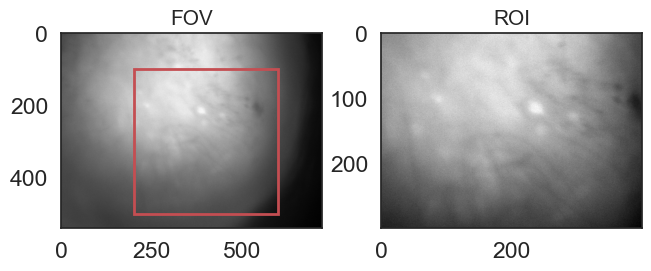

In [6]:
# Let's visualize the FOV and the ROI
aux.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path)

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

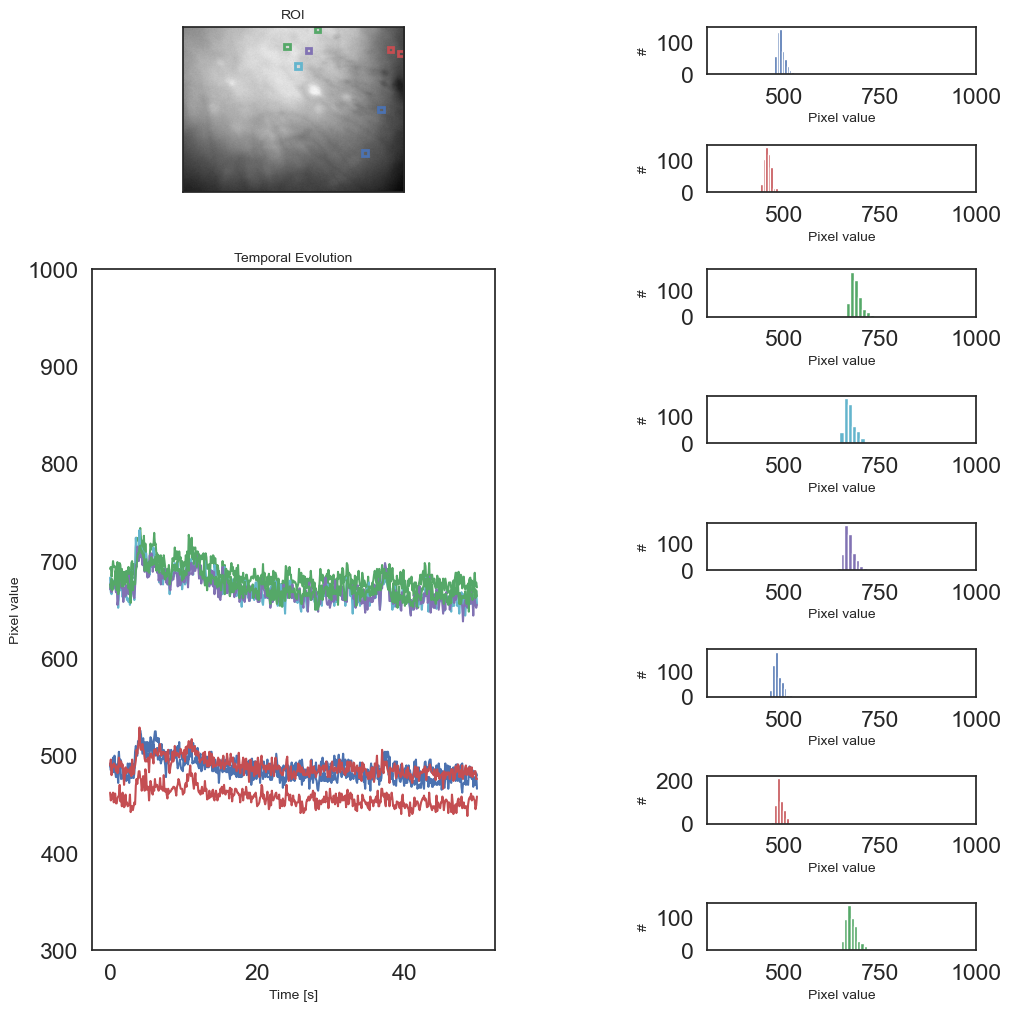

In [18]:
# Adapted from aux.temporal_evolution(), edited for customization purposes:

from random import randrange

def temporal_evolution(file_name=None, output_file_name=None, N=5, fontsize=10):
    '''
    After decoding this plots the time evolution of some pixel values in the ROI, the histogram if pixel values and
    the ROI with the mark of the position for the randomly selected pixels
    '''

    movie_original = cm.load(file_name)

    figure = plt.figure(constrained_layout=True)
    gs = figure.add_gridspec(N, 6)

    figure_ax1 = figure.add_subplot(gs[0:2, 0:3])
    figure_ax1.set_title('ROI', fontsize=fontsize)
    figure_ax1.set_yticks([])
    figure_ax1.set_xticks([])

    figure_ax2 = figure.add_subplot(gs[2:N, 0:3])
    figure_ax2.set_xlabel('Time [s]', fontsize=fontsize)
    figure_ax2.set_ylabel('Pixel value', fontsize=fontsize)
    figure_ax2.set_title('Temporal Evolution', fontsize=fontsize)
    figure_ax2.set_ylim((300, 1000))

    figure_ax1.imshow(movie_original[0, :, :], cmap='gray')
    color = ['b', 'r', 'g', 'c', 'm']

    for i in range(N):
        x = randrange(movie_original.shape[1]-5)+5
        y = randrange(movie_original.shape[2]-5)+5
        [x_, _x, y_, _y] = [x-5, x+5, y-5, y+5]
        rect = Rectangle((y_, x_), _y - y_, _x - x_, fill=False,
                         color=color[i % 5], linestyle='-', linewidth=2)
        figure_ax1.add_patch(rect)

        figure_ax2.plot(np.arange(
            0, movie_original.shape[0],)/10, movie_original[:, x, y], color=color[i % 5])

        figure_ax_i = figure.add_subplot(gs[i, 4:])
        figure_ax_i.hist(movie_original[:, x, y], N, color=color[i % 5])
        figure_ax_i.set_xlim((300, 1000))
        figure_ax_i.set_ylabel('#', fontsize=fontsize)
        figure_ax_i.set_xlabel('Pixel value', fontsize=fontsize)

    figure.set_size_inches([10., 10.])
    figure.savefig(output_file_name)

    return

temporal_evolution(input_tif_file_path, 'temporal_evolution.png', N=8, fontsize=10)

**Exercise 1 Answers:**
B: The difference in different regions is the direct brightness, but also spread of the pixel value range.
The background is darker, thus the pixel values will be darker too, lowering their pixel values in the histogram.
But even more important, pixels belonging to neurons are affected by the activity of the neuron, and the valeus will vary more. So variance and peaks not present in other neurons is a good indicator of neural pixels.
And probably something with the variance of the histogram plot asa well, but the random points did not turn out favorably enough to see that.

The temporal traces of the pixels have very low signal-to-noise ratio. 
There are effects like measurement errors, unexpected movements.
And you can see that when comparing the pixel values as well.
All pixel values follow roughly the same curve. Which is mostly noise and errors.

We run source extraction to enrich the meaningful data in the image.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


gSig_filt_vals: 0, Crispness: 0.0
gSig_filt_vals: 5, Crispness: 33.579193115234375
gSig_filt_vals: 10, Crispness: 48.5541877746582
gSig_filt_vals: 15, Crispness: 45.35432052612305
gSig_filt_vals: 20, Crispness: 41.73060607910156
gSig_filt_vals: 25, Crispness: 35.474761962890625
gSig_filt_vals: 30, Crispness: 33.25905227661133
gSig_filt_vals: 35, Crispness: 31.20488739013672
gSig_filt_vals: 40, Crispness: 30.38857078552246
gSig_filt_vals: 45, Crispness: 28.903671264648438


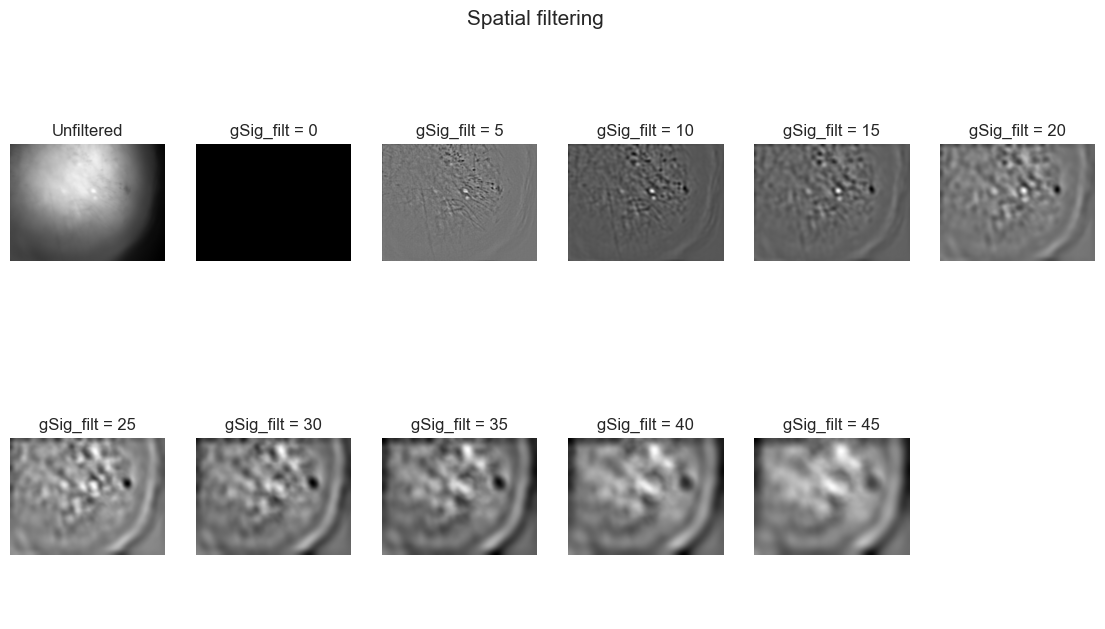

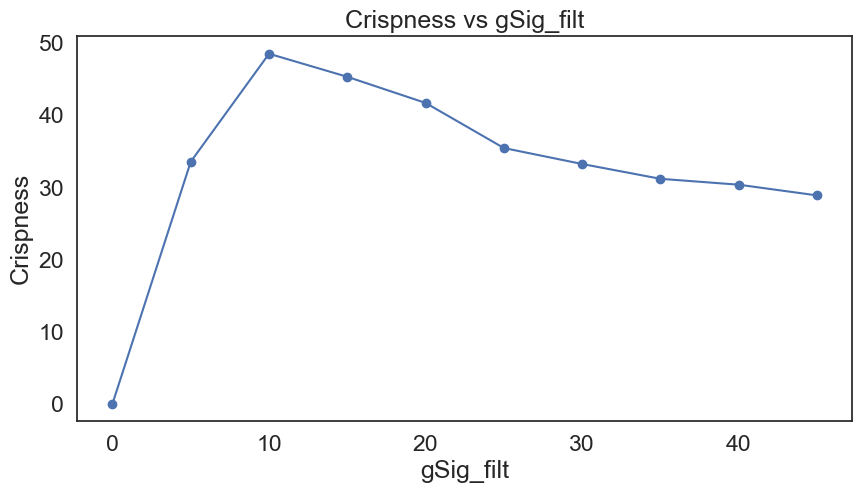

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


gSig_filt_vals: 0


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 967
Crispness elastic: 968
----------------------------------

gSig_filt_vals: 5


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 858
Crispness elastic: 882
----------------------------------

gSig_filt_vals: 10


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 823
Crispness elastic: 879
----------------------------------

gSig_filt_vals: 15


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00,  9.92it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 865
Crispness elastic: 905
----------------------------------

gSig_filt_vals: 20


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.49it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 990
Crispness elastic: 941
----------------------------------

gSig_filt_vals: 25


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.41it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 1030
Crispness elastic: 956
----------------------------------

gSig_filt_vals: 30


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.42it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 1038
Crispness elastic: 934
----------------------------------

gSig_filt_vals: 35


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 1047
Crispness elastic: 933
----------------------------------

gSig_filt_vals: 40


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.29it/s]
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


Crispness original: 1040
Crispness rigid: 1051
Crispness elastic: 933
----------------------------------

gSig_filt_vals: 45


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


Crispness original: 1040
Crispness rigid: 1054
Crispness elastic: 938
----------------------------------



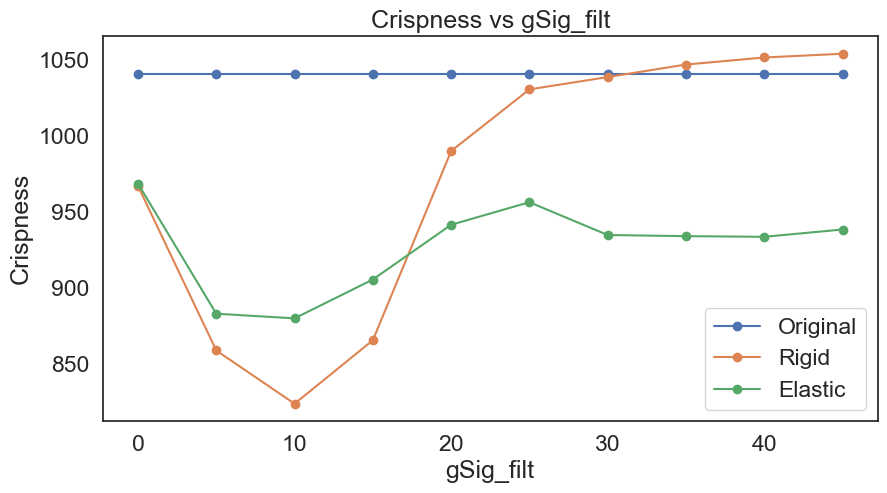

In [8]:
import math    

# Adapted from aux.get_fig_gSig_filt_vals(), edited for customization purposes:
def get_fig_gSig_filt_vals(file_name=None, gSig_filt_vals=None, output_file=None):
    '''
    Plot original FOV and several versions of spatial filtering for comparison
    :param row: analisis state row for which the filtering is computed
    :param gSig_filt_vals: array containing size of spatial filters that will be applyed
    :return: figure
    '''
    m = cm.load(file_name)
    temp = cm.motion_correction.bin_median(m)
    N = len(gSig_filt_vals)
    fig, axes = plt.subplots(2, int(math.ceil((N + 1) / 2)))
    axes[0, 0].imshow(temp, cmap='gray')
    axes[0, 0].set_title('Unfiltered', fontsize=12)
    axes[0, 0].axis('off')

    crispnesses = []
    for i in range(0, N):
        gSig_filt = gSig_filt_vals[i]
        m_filt = [high_pass_filter_space(
            m_, (gSig_filt, gSig_filt)) for m_ in m]
        temp_filt = cm.motion_correction.bin_median(m_filt)
        crispness = frobenius(temp_filt)
        print(f"gSig_filt_vals: {gSig_filt}, Crispness: {crispness}")
        crispnesses.append(crispness)

        axes.flatten()[i + 1].imshow(temp_filt, cmap='gray')
        axes.flatten()[i + 1].set_title(f'gSig_filt = {gSig_filt}', fontsize=12)
        axes.flatten()[i + 1].axis('off')
    if N + 1 != axes.size:
        for i in range(N + 1, axes.size):
            axes.flatten()[i].axis('off')
    # Save figure
    fig.suptitle('Spatial filtering', fontsize=15)
    fig.set_size_inches([14., 7.])
    fig.savefig(output_file)

    plt.figure(figsize=(10, 5))
    plt.plot(gSig_filt_vals, crispnesses, 'o-')
    plt.xlabel('gSig_filt')
    plt.ylabel('Crispness')
    plt.title('Crispness vs gSig_filt')
    plt.savefig('gSig_filt_vs_crispness.png')
    plt.show()

    return

def frobenius(img):
    Ix, Iy = np.gradient(img)
    crispness = np.sqrt((Ix**2 + Iy**2).sum())
    return crispness

def motion_correction(pw_rigid=True, gSig_filt=(5, 5), max_shifts=(25, 25), niter_rig=1, strides=(48, 48), overlaps=(96, 96), upsample_factor_grid=1, num_frames_split=80, max_deviation_rigid=15, shifts_opencv=True, use_cuda=False, nonneg_movie=True, border_nan='copy'):
    # Define parameters for motion correction in a dictionary
    parameters_motion_correction = { 'pw_rigid': pw_rigid,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                    'gSig_filt': gSig_filt,     # size of high pass spatial filtering, used in 1p data
                                    'max_shifts': max_shifts,  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                    'niter_rig': niter_rig ,
                                    'strides': strides,     # create a new patch every x pixels for pw-rigid correction
                                    'overlaps': overlaps,    # overlap between pathes (size of patch strides+overlaps)
                                    'upsample_factor_grid': upsample_factor_grid,
                                    'num_frames_split': num_frames_split,  # length in frames of each chunk of the movie (to be processed in parallel)
                                    'max_deviation_rigid': max_deviation_rigid, # maximum deviation allowed for patch with respect to rigid shifts
                                    'shifts_opencv': shifts_opencv, 
                                    'use_cuda': use_cuda, 
                                    'nonneg_movie': nonneg_movie,
                                    'border_nan': border_nan}
    
    # We compute and store the minimum value of the movie, that the algorithm needs to make values all positive
    original_movie = cm.load(input_tif_file_path)
    parameters_motion_correction['min_mov'] = np.min(original_movie) 

    # pass parameters to caiman object
    opts = params.CNMFParams(params_dict = parameters_motion_correction)

    n_processes = psutil.cpu_count() # counts local cpus
    cm.cluster.stop_server() #stop any already running clusters
    # Start a new cluster
    c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                    n_processes=n_processes,
                                                    single_thread=False)
    
    #make directory to save motion corrected videos
    Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

    #create an object for motion correction
    mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))

    # Perform rigid motion correction
    mc.motion_correct_rigid(save_movie = True, template = None)

    #perform non-rigid motion correction
    total_template_rig = mc.total_template_rig
    mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
    
    fname_tot_els = mc.fname_tot_els[0]

    #reshape memmap files for source extraction
    m_els = cm.load(fname_tot_els)
    fname_tot_els  = m_els.save('motion_corrected_video.mmap',  order='C')
    src = Path(fname_tot_els)
    os.remove(f"data/motion_corrected/{src.name}")
    src.rename(f"data/motion_corrected/{src.name}")
    # Path(fname_tot_els).rename(f"data/motion_corrected/{fname_tot_els}")

    final_size = mc.total_template_els.shape

    m_rig = cm.load(mc.fname_tot_rig)
    m_els = cm.load(mc.fname_tot_els)

    crispness_orig = crispness_movie(input_tif_file_path_FOV, final_size)
    crispness_rig = crispness_movie(mc.fname_tot_rig[0], final_size)
    crispness_els = crispness_movie(mc.fname_tot_els[0], final_size)

    dview.terminate()
    return crispness_orig, crispness_rig, crispness_els

def crispness_movie(filepath, final_size, winsize = 100, swap_dim = False, resize_fact_flow = .1):
    tmpl, correlations, flows, norms, crispness = cm.motion_correction.compute_metrics_motion_correction(
        filepath, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)
    return crispness

N = 10
max_size = 50

gSig_filt_vals = range(0, max_size, math.floor(max_size / N))
get_fig_gSig_filt_vals(input_tif_file_path_FOV, gSig_filt_vals, output_file="gSig_filt_vals.png")
origs, rigs, elss = [], [], []
for filt_val in gSig_filt_vals:
    print(f"gSig_filt_vals: {filt_val}")
    crispness_orig, crispness_rig, crispness_els = motion_correction(gSig_filt=(filt_val, filt_val))
    print('Crispness original: '+ str(int(crispness_orig)))
    print('Crispness rigid: '+ str(int(crispness_rig)))
    print('Crispness elastic: '+ str(int(crispness_els)))
    print('----------------------------------\n')
    origs.append(crispness_orig)
    rigs.append(crispness_rig)
    elss.append(crispness_els)
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(gSig_filt_vals, origs, 'o-', label='Original')
plt.plot(gSig_filt_vals, rigs, 'o-', label='Rigid')
plt.plot(gSig_filt_vals, elss, 'o-', label='Elastic')
plt.xlabel('gSig_filt')
plt.ylabel('Crispness')
plt.title('Crispness vs gSig_filt')
plt.legend()
plt.savefig('gSig_filt_vs_crispness.png')
plt.show()

**Exercise 2 Answers:**
Crispness is defined as the sum of gradient magnitudes.
As we sweep a highpass filter from big to small gSig_filt_values, more of the lower-frequency spatial information should get removed. By removing low-frequency information, the mid-frequency edges pop out. This is when peak crispness is achieved. At some point we sweep too high and the meaningful frequencies get removed as well, which is when we cannot interpret anything anymore and the image starts becoming kinda noisy.

The most important parameters according to Pnevmatikakis et al. are:
- max_shifts
- strides
- overlaps 
- max_deviation_rigid
- subpixel
- interpolation method
- number of iterations

I will not show the impact of other parameters, this code takes too long to run.

## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.

Text(0.5, 1.0, 'PNR image')

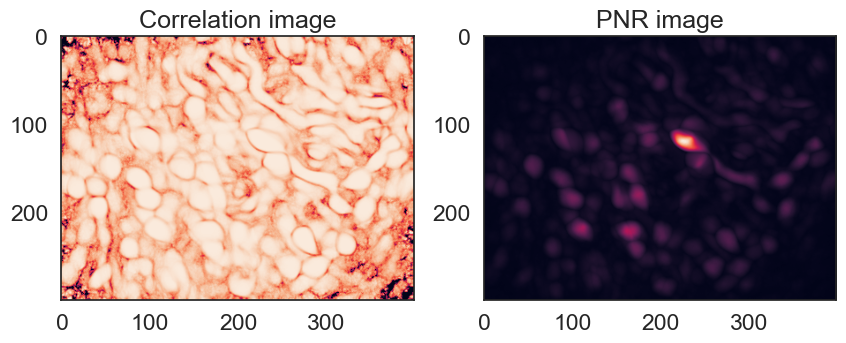

In [4]:
# load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

# compute correlation and pnr images 
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images[::1], gSig=gSig,swap_dim=False)

figure, axes = plt.subplots(1, 2,figsize=(10,5))
axes[0].imshow(corr_image)
axes[0].set_title('Correlation image')
axes[1].imshow(pnr_image)
axes[1].set_title('PNR image')

In [5]:
def source_extraction(images, min_corr, min_pnr):
    # create dictionary with source extraction parameters

    parameters_source_extraction = {
        'init': {
            'method_init':      'corr_pnr',
            'K':                None,
            'gSig':             (4, 4),
            'gSiz':             (17, 17),
            'min_corr':         min_corr,
            'min_pnr':          min_pnr,
            'normalize_init':   False,
            'center_psf':       True,
            'border_pix':       0,
        },
        'spatial': {
            'ssub':             2,
            'tsub':             1,
            'nb':               0,
            'nb_patch':         0,
            'update_spatial':   True,
        },
        'temporal': {
            'p':                1,
            'tsub':             1,
            'ssub':             2,
        },
        'deconvolution': {
            'method':           'oasis',
        },
        'background': {
            'low_rank_background': None,
            'ring_size_factor':    1.4,
        },
        'merge': {
            'merge_thr':        0.7,
            'rf':               60,
        },
        # you can also add a 'quality' block here if desired
    }
    
    # create caiman parameters objects
    opts = params.CNMFParams(params_dict=parameters_source_extraction)
    
    n_processes = psutil.cpu_count() # counts local cpus
    cm.cluster.stop_server() #stop any already running clusters
    # Start a new cluster
    c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                    n_processes=n_processes,
                                                    single_thread=False)

    cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
    cnmf_object.fit(images)

    # Save the cnmf object as a hdf5 file
    Path("data/source_extracted").mkdir(parents=True, exist_ok=True)
    output_cnmf_file_path = 'data/source_extracted/calcium_video_0_cnmf.hdf5'
    cnmf_object.save(output_cnmf_file_path)

    cnmf_object.estimates.C.shape
    dview.terminate()

    return cnmf_object

In [6]:
def plot_cnmf_object(cnmf_object):
    # display footprints in the ROI
    figure, axes = plt.subplots(1,figsize=(5,5))
    plt.title(f'Extracted sources (N={cnmf_object.estimates.A.shape[1]})')
    pos = axes.imshow(corr_image)
    coordinates = cm.utils.visualization.get_contours(cnmf_object.estimates.A, np.shape(corr_image), 0.2, 'max')
    for c in coordinates:
        v = c['coordinates']
        c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                        np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
        axes.plot(*v.T, c='k')

    # plot temporal traces
    figure, axes = plt.subplots(1,figsize=(10,5))
    C_0 = cnmf_object.estimates.C.copy()
    C_0[1] += C_0[0].min()
    for i in range(1, len(C_0)):
        C_0[i] += C_0[i].min() + C_0[:i].max()
        axes.plot(C_0[i],c='k')
    axes.set_xlabel('time (frames)')
    axes.set_yticks([])
    sns.despine()
    axes.set_ylabel('activity')

In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key temporal/tsub was not consumed. This is a bug!
In setting CNMFParams, provided key temporal/ssub was not consumed. This is a bug!
In setting CNMFParams, provided toplevel key deconvolution was unused. This is a bug!
In setting CNMFParams, provided toplevel key background was unused. This is a bug!
In setting CNMFParams, provided toplevel key merge was unused. This is a bug!


min_pnr: 1


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 3


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 5


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 7


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 9


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 11


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_pnr: 13


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


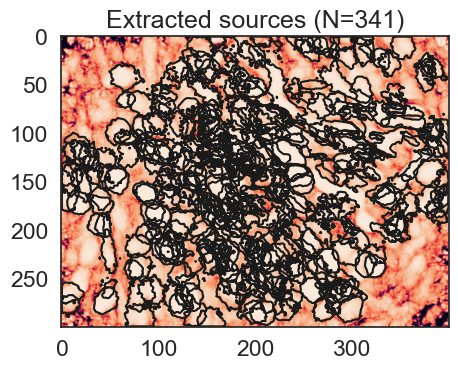

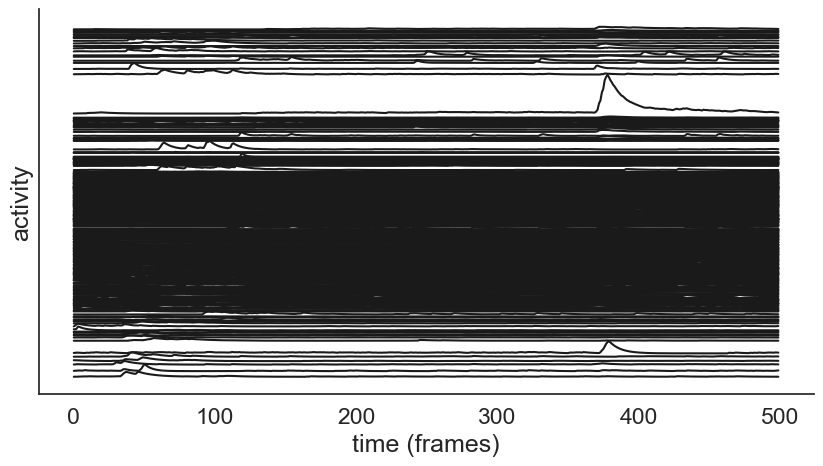

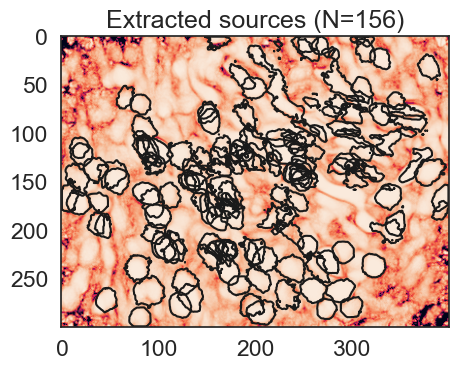

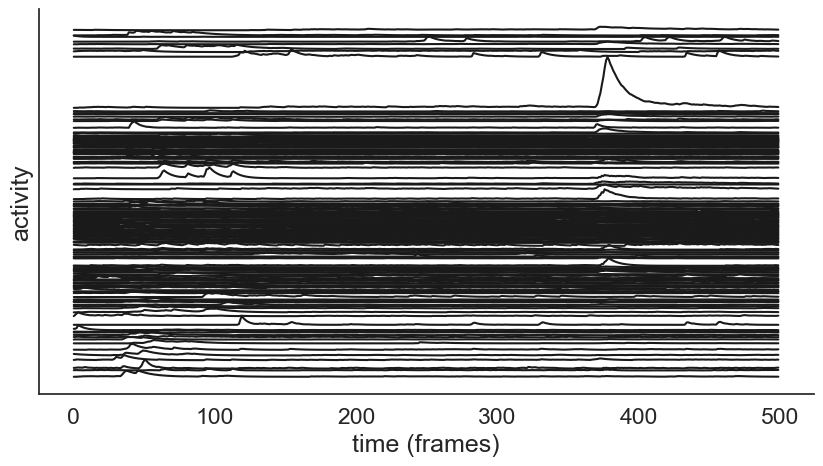

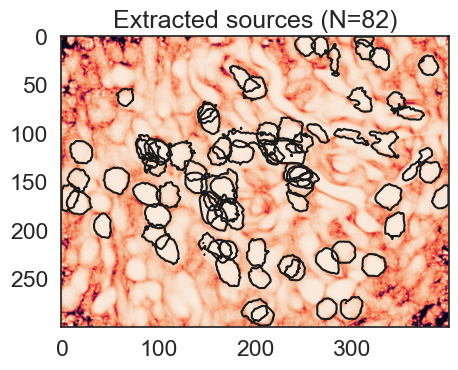

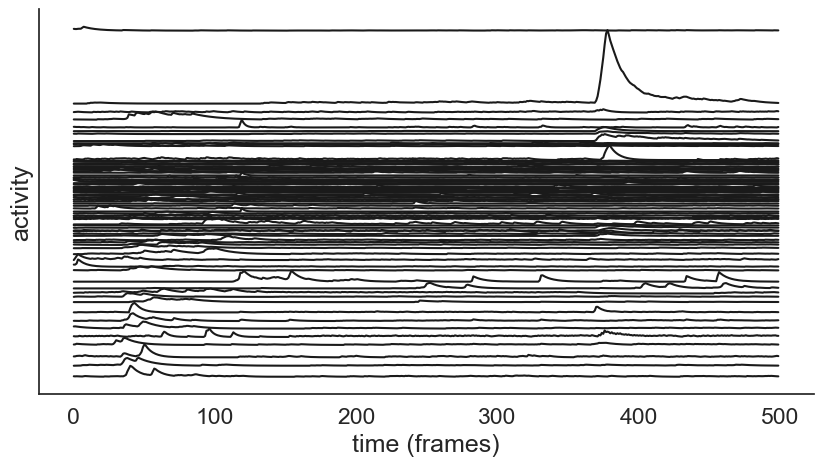

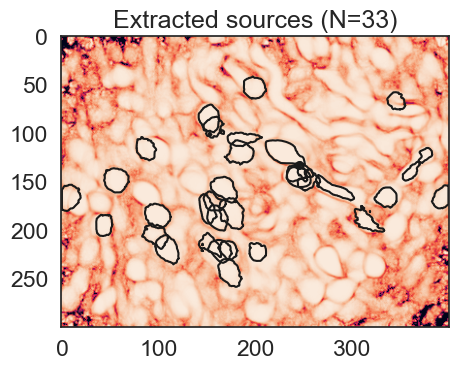

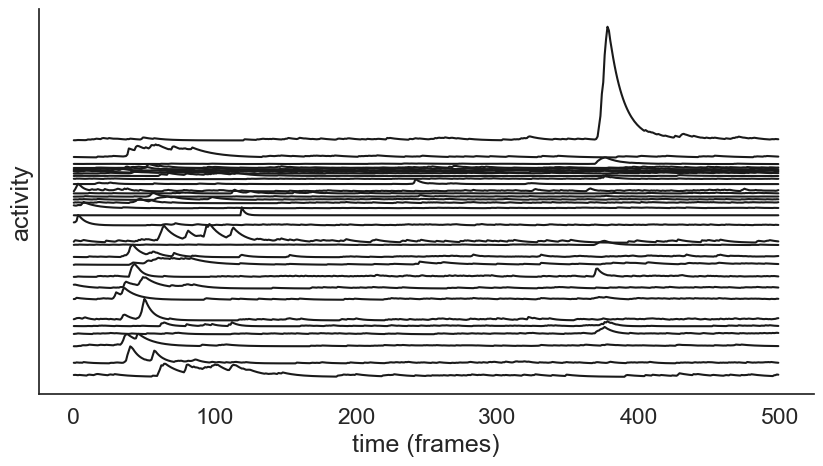

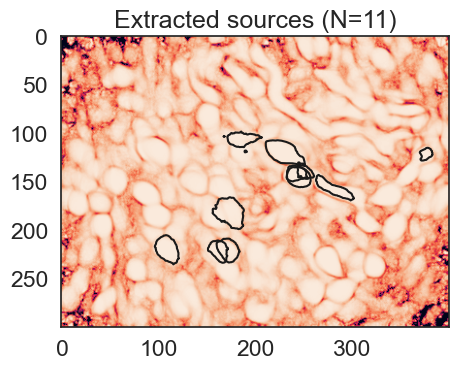

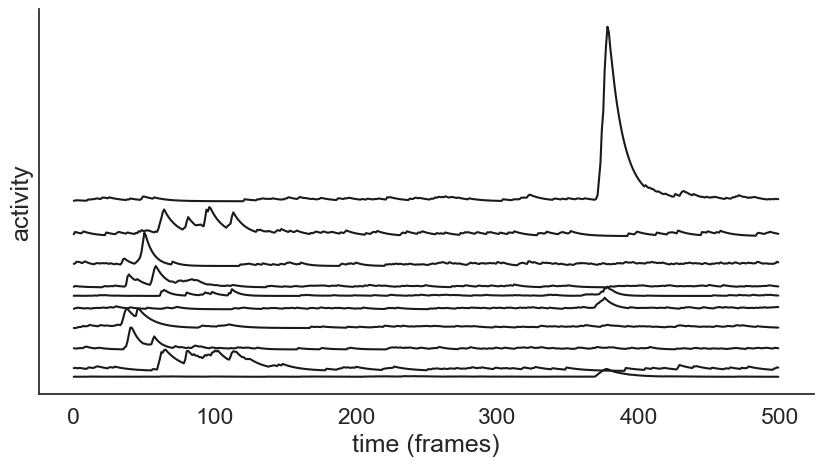

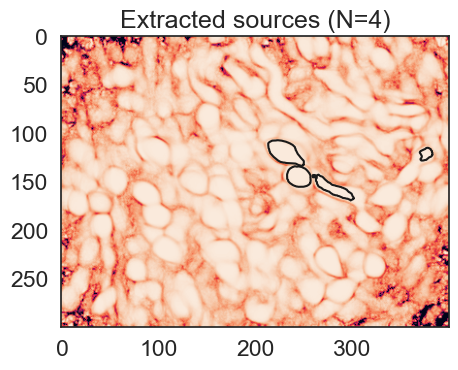

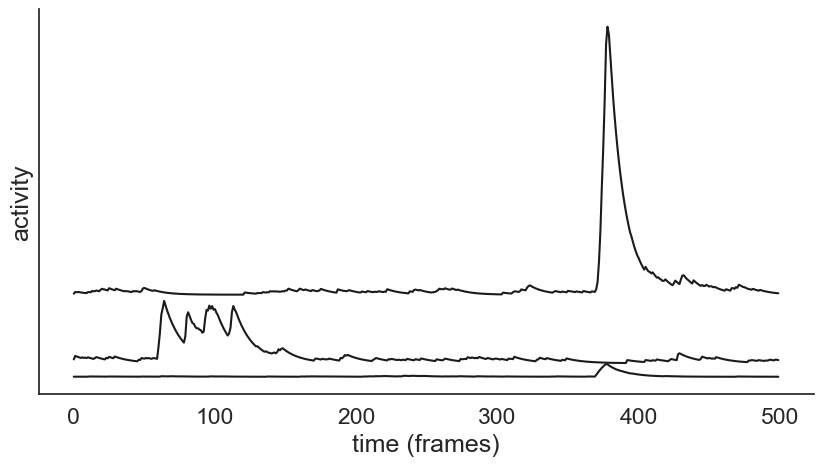

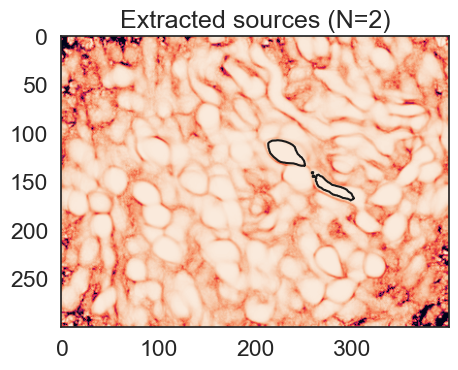

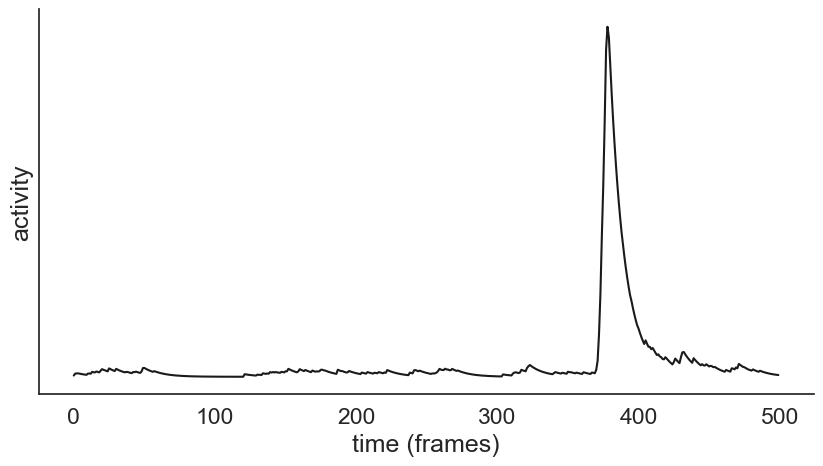

In [7]:
# 1
min_pnr_range = np.arange(1, 15, 2)
for min_pnr in min_pnr_range:
    print(f"min_pnr: {min_pnr}")
    # run source extraction
    cnmf_object = source_extraction(images, min_corr=0.6, min_pnr=min_pnr)
    plot_cnmf_object(cnmf_object)

In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key temporal/tsub was not consumed. This is a bug!
In setting CNMFParams, provided key temporal/ssub was not consumed. This is a bug!
In setting CNMFParams, provided toplevel key deconvolution was unused. This is a bug!
In setting CNMFParams, provided toplevel key background was unused. This is a bug!
In setting CNMFParams, provided toplevel key merge was unused. This is a bug!


min_corr: 0.1


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.2


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.30000000000000004


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.4


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.5


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.6


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.7000000000000001


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.8


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]
In setting CNMFParams, provided key init/border_pix was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/ssub was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/tsub was not consumed. This is a bug!
The 'nb' parameter can only be set in the init part of CNMFParams. Attempts to set it elsewhere are ignored
In setting CNMFParams, provided key spatial/nb_patch was not consumed. This is a bug!
In setting CNMFParams, provided key spatial/update_spatial was not consumed. This is a bug!
In setting CNMFParams, provided key 

min_corr: 0.9


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],
c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,

1


c:\Users\Emiel\miniforge3\envs\caiman\Lib\site-packages\caiman\source_extraction\cnmf\initialization.py:1364: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  f_in = np.linalg.lstsq(b_in, B)[0]


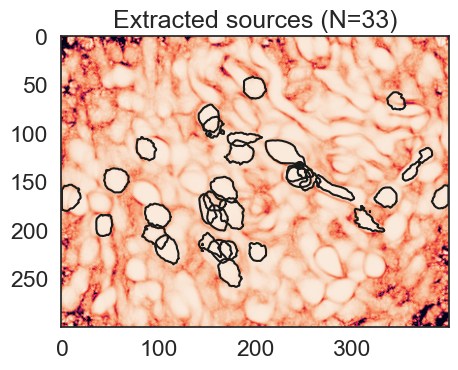

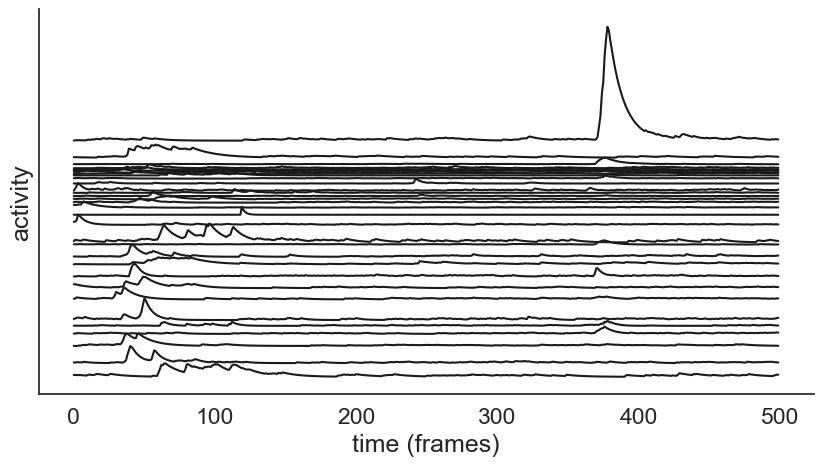

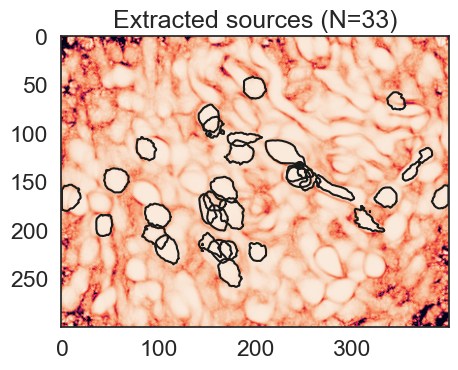

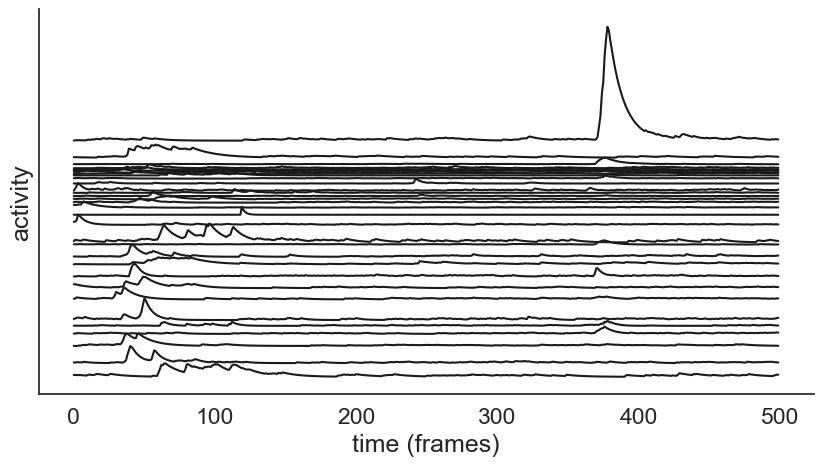

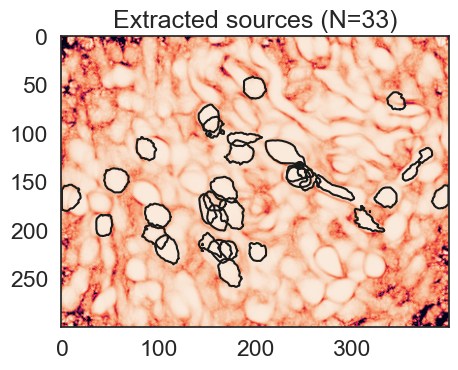

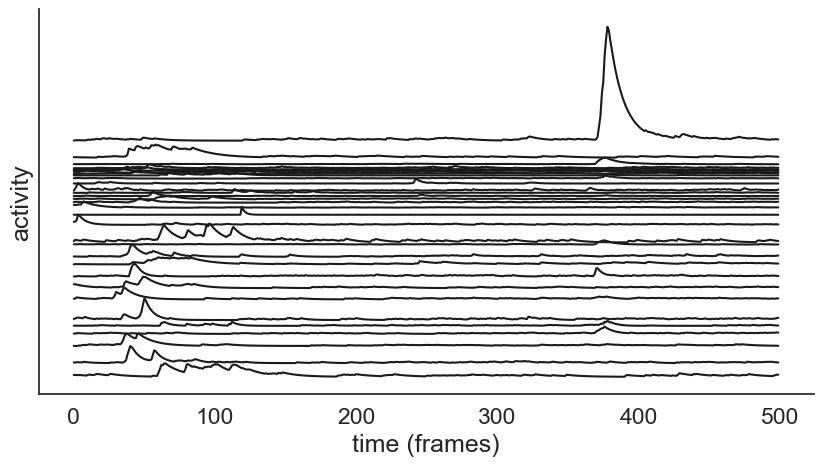

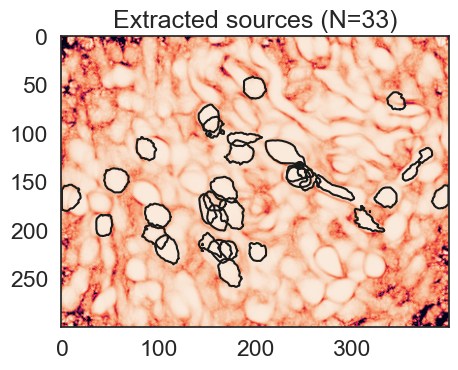

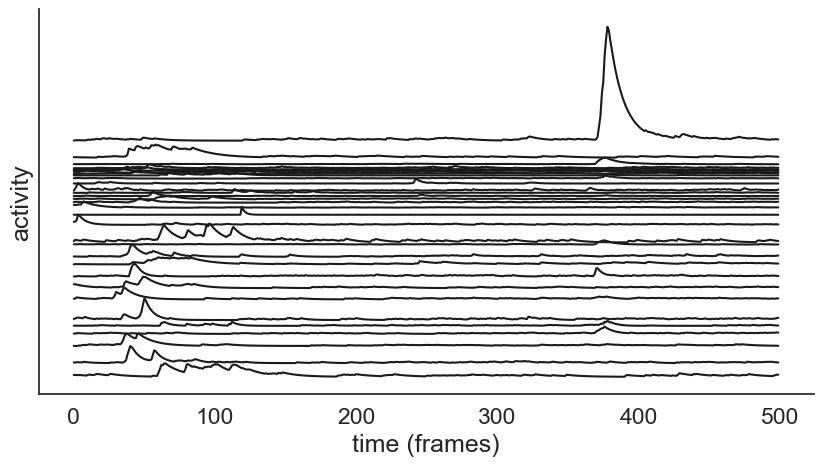

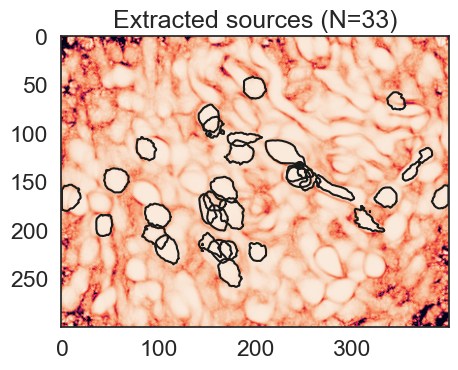

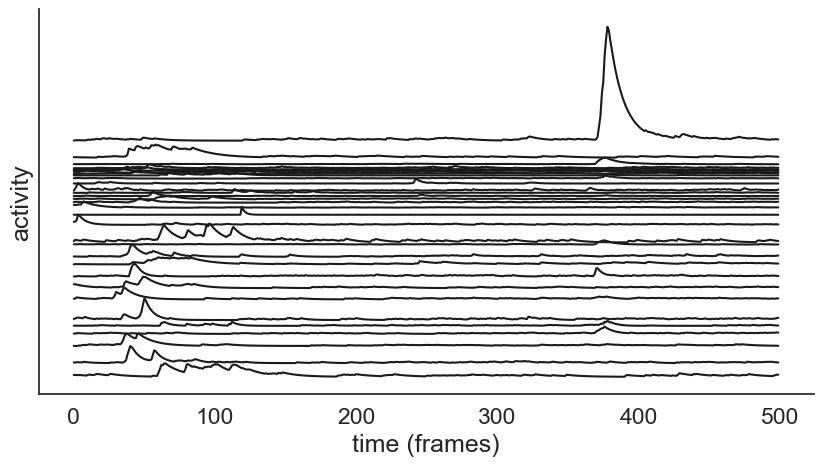

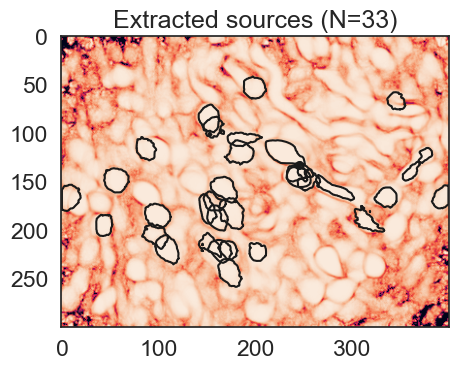

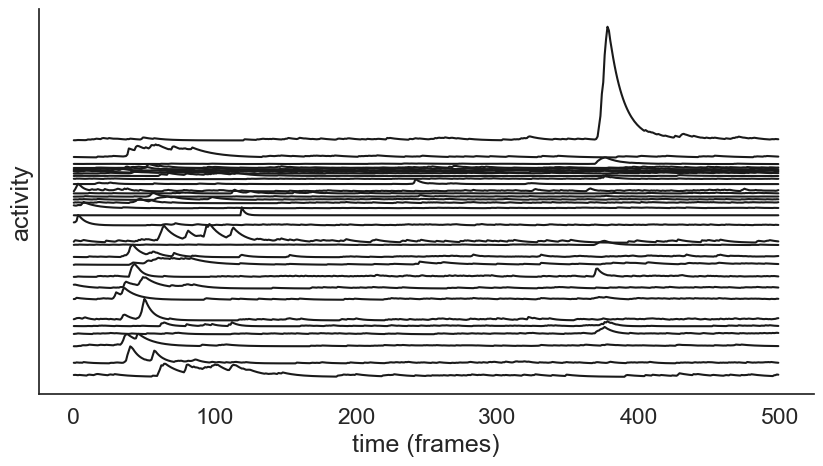

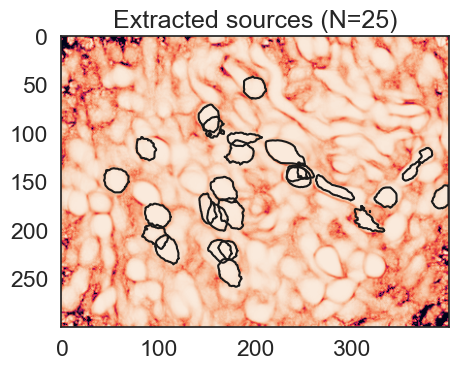

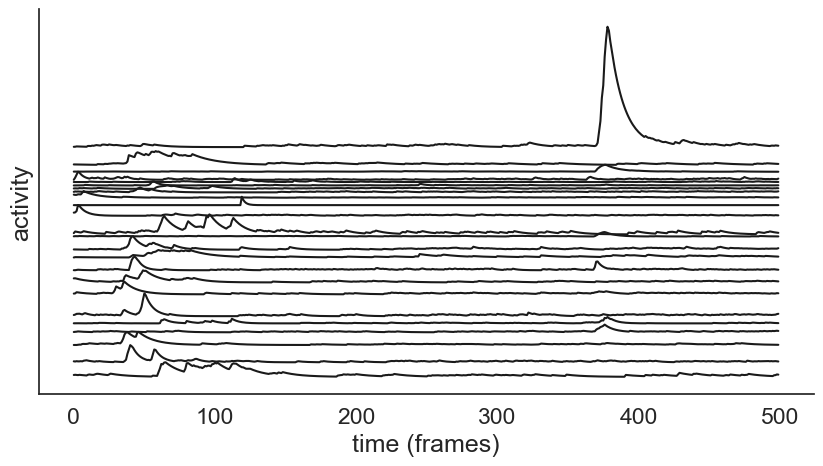

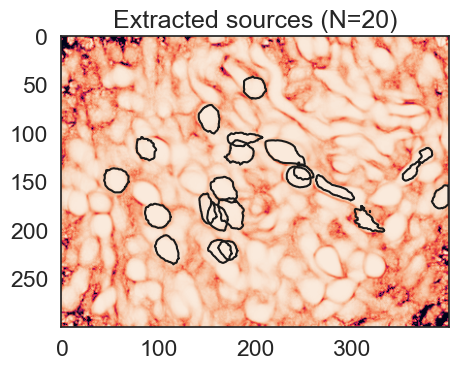

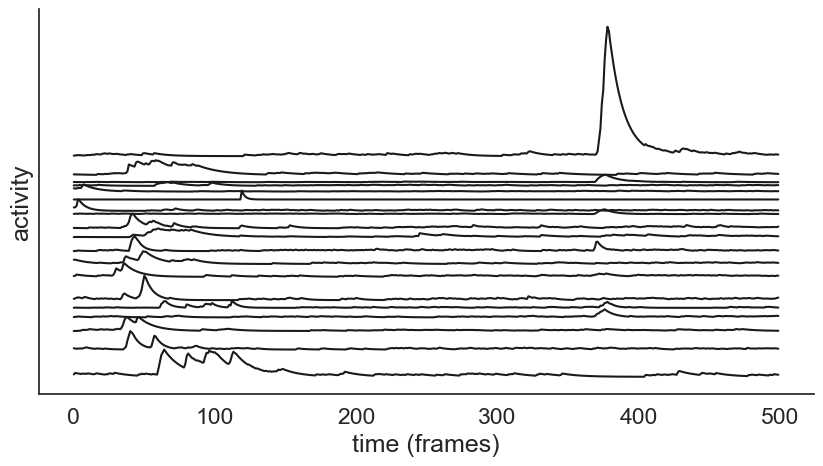

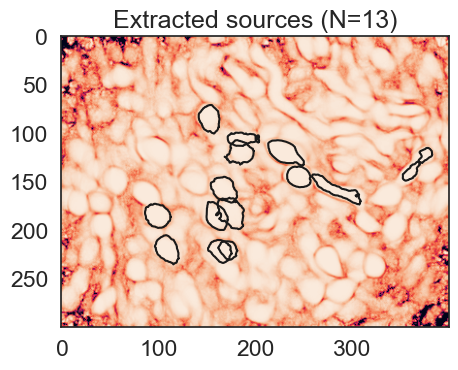

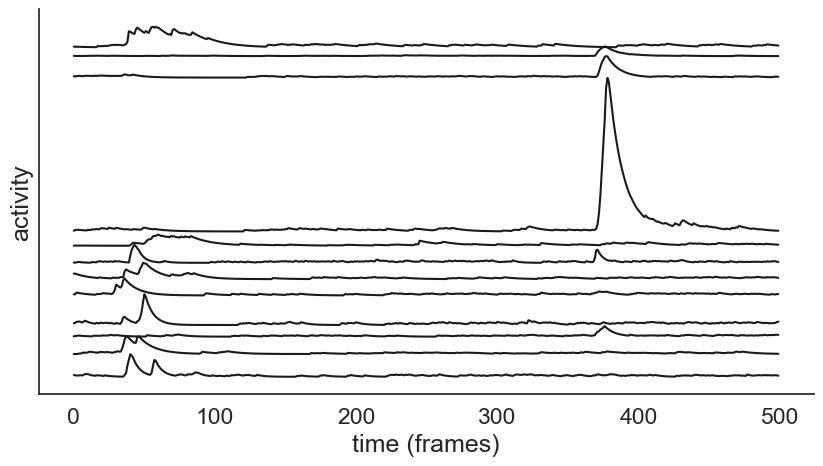

In [8]:
# 2
min_corr_range = np.arange(0.1, 1, 0.1)
for min_corr in min_corr_range:
    print(f"min_corr: {min_corr}")
    # run source extraction
    cnmf_object = source_extraction(images, min_corr=min_corr, min_pnr=7)
    plot_cnmf_object(cnmf_object)

**Exercise 3 Answers:**

The highest number of neurons is achieved by having the min_pnr_range variable as low as possible. Setting this value higher will ensure only the most active neurons are taken into account.
For the min-corr range, again, the lowest values lead to the most neurons detected and higher values are more selective with neurons.

It's not advantageous per se to have as many neurons as possible, first and foremost since you can't see the trees for the forest anymore. But also since at some point you can question how well the algorithm can still perform with such a low signal to noise ratio. Perhaps what's identified as one multiple neurons is really just one.
And if the threshold for neuron detection is so low, at some point you can question whether the algorithm is extracting noise (and the extraction not being noise does not mean the peaks are still visible).
So it's best to extract enough neurons that you can clearly distinguish them as such, but remove any extracted neurons that might be ambiguous.

